<a href="https://colab.research.google.com/github/SomTambe/pclub-transfer-learning/blob/main/PClub_Transfer_Learning_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PClub Transfer Learning Hackathon**

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Create a Kaggle Account. Then follow the steps given here to download the API key file. It is very simple!

[Kaggle API Credentials](https://github.com/Kaggle/kaggle-api#api-credentials)

Just download the file, and upload it here to the Colab Environment.

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Giving permissions
!kaggle datasets list # Let's see if everything is working

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           2175  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11           1496  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           2628  
Cornell-University/arxiv                               arXiv Dataset                                     889MB  2020-09-26 23:51:17           3143  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification # Downloading the dataset
!unzip intel-image-classification.zip
!rm -rf intel-image-classification.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import glob

In [ ]:
data=glob.glob('seg_train/**/*.jpg',recursive=True)
classes=[]
for f in data:
    arr=f.split('/')
    if arr[-2] not in classes:
        classes.append(arr[-2])
print(classes)
print(len(classes))

['glacier', 'buildings', 'street', 'sea', 'mountain', 'forest']
6


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
class PClubDataset(Dataset):
    """
    Custom dataset class built to load the Intel Image classification 
    dataset for our Transfer Learning Hackathon.

    Args:
        dir (string): Directory where files have been extracted. Don't change this.
        train (bool): True for training dataset. False for testing.
    """
    def __init__(self,dir='./',transform=None,train=True):
        self.dir=dir
        self.train=train
        self.transform=transform
        if train is True:
            self.data=glob.glob('seg_train/**/*.jpg',recursive=True)
        if train is False:
            self.data=glob.glob('seg_test/**/*.jpg',recursive=True)
        self.classes=['mountain', 'street', 'buildings', 'forest', 'glacier', 'sea']

    def __len__(self):
        return (len(self.data)-1)

    def __getitem__(self,ind):
        image=Image.open(self.data[ind])
        if self.transform is not None:
            image=self.transform(image)
        label=self.classes.index(self.data[ind].split('/')[-2])
        label=torch.tensor([label])
        return image,label

In [ ]:
# This part is just for testing purposes. We import the dataset later in the next blocks.
transform=transforms.Compose([
                              transforms.ToTensor(),
                              ])
trainset=PClubDataset(transform=transform,train=True)

torch.Size([3, 150, 150]) tensor([0])


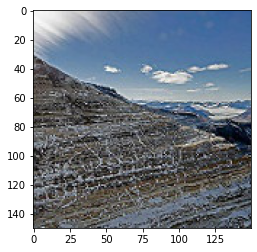

glacier


In [ ]:
# Let's see if it works. Let us try plotting the image.
sample=trainset.__getitem__(10000)
print(sample[0].shape,sample[1])
plt.imshow(np.array(sample[0]).transpose((1,2,0))) # numpy array in the format h x w x 3
plt.show()
print(classes[sample[1]])

In [ ]:
# It finally works! We have the tensors for each and every image now. Let's prepare the dataloader.
transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# We normalize all the values from the range of 0 to 255, with a mean of 0.5 and std of 0.5.
trainset=PClubDataset(transform=transform,train=True)
trainloader=loader.DataLoader(dataset=trainset,batch_size=16,shuffle=True)

In [ ]:
# We shall use the Resnet-50 pretrained model here. 
# You can find out more models here - https://pytorch.org/docs/stable/torchvision/models.html
# All these models are trained on the ImageNet dataset, which consists of 1000 classes. Therefore,
# we use these models to leverage the benefits of their learned features, and apply them to our own task.
model=torchvision.models.resnet50(pretrained=True)
# Here I'll give an example of how to replace a layer
num_ftrs=model.fc.in_features # Gives us the input features in the last fully-connected layer.

# Let us replace the fc layer with our layer, which we will train for our use case.
model.fc=nn.Linear(in_features=num_ftrs,out_features=len(classes))

# Let us see what changes have come in our model.
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Now your model is ready, your data is ready. All you need to do is train your network. 
# This is very similar to your classic MNIST training problem. I will give you an example of how to do it here.

# I won't provide the complete code, but it is widely available on the internet. You can derive your method from 
# there.